In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from scipy.stats import pearsonr
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels
plt.rcParams['figure.figsize'] = (18, 12)

In [2]:
data_inicio = '2008-01-01'
data_fim = '2020-01-01'

In [3]:
df = data.DataReader('azul4.sa', 'yahoo', data_inicio, data_fim)
df['data_pregao'] = df.index
df['mm5D'] = df['Adj Close'].rolling(5).mean()
df['mm21D'] = df['Adj Close'].rolling(21).mean()
df.dropna(inplace=True)

In [4]:
df_train = df['Adj Close']

In [5]:
df_train

Date
2017-05-12    25.250000
2017-05-15    25.680000
2017-05-16    26.299999
2017-05-17    26.500000
2017-05-18    22.719999
                ...    
2019-12-20    57.000000
2019-12-23    57.599998
2019-12-26    57.070000
2019-12-27    57.799999
2019-12-30    58.279999
Name: Adj Close, Length: 658, dtype: float64

In [6]:
#Is the data stationary?
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_train)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.9676382356975407  if above 0.05, data is not stationary


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose 

decomposed = seasonal_decompose(df_train, period = 1,
                            model ='additive')


In [8]:
trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

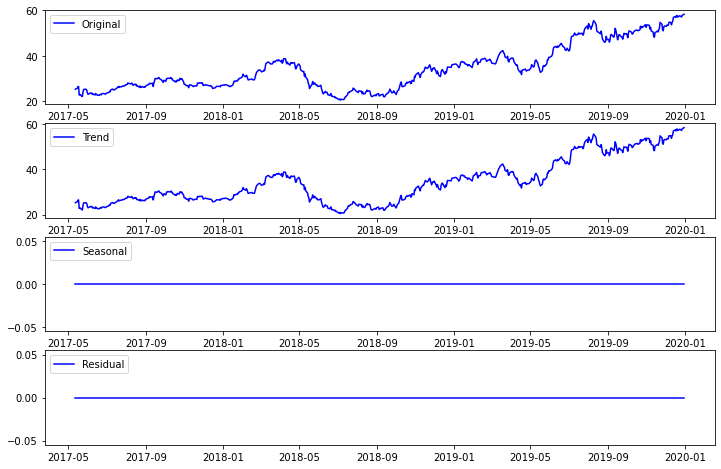

In [9]:

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_train, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='blue')
plt.legend(loc='upper left')
plt.show()

In [10]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['Adj Close'], start_p = 2, d=None, start_q = 2, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 1, D=None, start_Q=1, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          seasonal_test = 'ocsb',
                          n_jobs = -1, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)           

C:\Users\pcosm\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1641.184, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1643.501, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1641.508, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1640.241, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1643.835, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1638.373, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1640.238, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1642.233, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1638.689, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1636.399, Time=0.12 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=1638.288, Time=0.28 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1638.292, Time=0.32 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=1640.274, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1636.732, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0

In [11]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -812.810
Date:                Fri, 01 Oct 2021   AIC                           1635.620
Time:                        14:45:25   BIC                           1658.058
Sample:                             0   HQIC                          1644.319
                                - 658                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0500      0.031      1.596      0.110      -0.011       0.111
ma.L1          0.1005      0.035      2.847      0.004       0.031       0.170
ma.L2         -0.0830      0.031     -2.658      0.0

In [12]:
size = int(len(df_train) * 0.66)
X_train, X_test = df_train[0:size], df_train[size:len(df_train)]

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(df_train,  
                order = (0, 1, 3),  
                seasonal_order =(0, 0, 0, 12)) 


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [14]:
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  658
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -814.092
Date:                Fri, 01 Oct 2021   AIC                           1636.184
Time:                        14:45:25   BIC                           1654.134
Sample:                             0   HQIC                          1643.143
                                - 658                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1045      0.035      2.977      0.003       0.036       0.173
ma.L2         -0.0785      0.032     -2.486      0.013      -0.140      -0.017
ma.L3         -0.0605      0.036     -1.669      0.095      -0.132       0.011
sigma2         0.6979      0.029     24.245      0.000       0.641       0.754
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               100.41
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index)

In [16]:
train_prediction.head(40)

Date
2017-05-12     0.000000
2017-05-15    25.250002
2017-05-16    25.722585
2017-05-17    26.326824
2017-05-18    26.447562
2017-05-19    22.282245
2017-05-22    23.357116
2017-05-23    22.248289
2017-05-24    22.065593
2017-05-25    24.233389
2017-05-26    25.066373
2017-05-29    25.042170
2017-05-30    25.163218
2017-05-31    24.795391
2017-06-01    23.478402
2017-06-02    23.063536
2017-06-05    23.280583
2017-06-06    23.654779
2017-06-07    23.419776
2017-06-08    23.580874
2017-06-09    22.828211
2017-06-12    23.227982
2017-06-13    22.660758
2017-06-14    23.444017
2017-06-15    22.820990
2017-06-16    22.909237
2017-06-19    22.561259
2017-06-20    22.625891
2017-06-21    23.001377
2017-06-22    22.972076
2017-06-23    22.762501
2017-06-26    23.380826
2017-06-27    23.314227
2017-06-28    23.212568
2017-06-29    23.073046
2017-06-30    23.150244
2017-07-03    23.484894
2017-07-04    23.761791
2017-07-05    23.896809
2017-07-06    24.279950
Name: predicted_mean, dtype: float6

In [17]:
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted closing price') 

In [18]:
prediction

Date
2019-02-05    38.077762
2019-02-06    38.563079
2019-02-07    37.068720
2019-02-08    36.155207
2019-02-11    37.234511
                ...    
2019-12-20    57.656270
2019-12-23    56.876545
2019-12-26    57.726972
2019-12-27    56.984261
2019-12-30    57.893053
Name: Predicted closing price, Length: 224, dtype: float64

<AxesSubplot:xlabel='Date'>

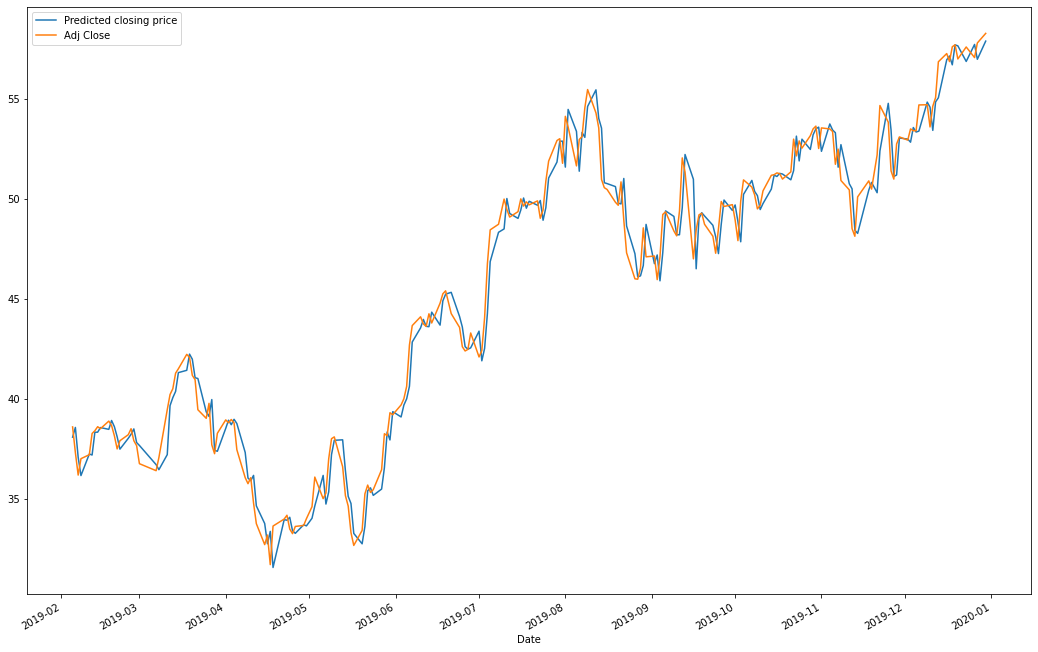

In [19]:
prediction.plot(legend = True) 
X_test.plot(legend = True) 

In [20]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.41 RMSE
Test Score: 1.02 RMSE


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


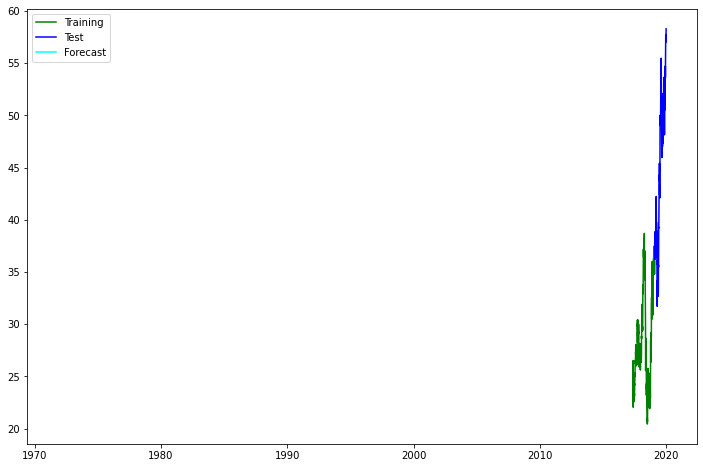

In [21]:
#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(df_train),  
                          end = (len(df_train)-1) + 1 * 1,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='blue')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()